In [1]:
import numpy as n
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

> ### Download the training dataset
- 1) use the DIV2K Dataset 
- 2) single-image super-resolution dataset with 1,000 images of scenes with various sorts of degradations, 
   - 800 images for training, 
   - 100 images for validation, 
   - 100 images for testing. 
- 3) We use 4x bicubic downsampled images as our "low quality" reference.

In [2]:
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

In [3]:
## To define train_data and validation_data from div2k_data
train_data = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train_data.cache()

validation_data = div2k_data.as_dataset(split="validation", as_supervised=True)
validation_cache = validation_data.cache()

>### Image Argumentation
- Flip, crip and resize images

In [4]:
def flip_left_right(lowres_img, highres_img):
    """flips images to left and right""" 
    
    rn = tf.random.uniform(shape=(), maxval=1)
    
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img)
        )
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""
    
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, high_crop_size, scale=4):
    """Crop image size
    low_res: 24 x 24
    high_res: 96 x 96"""
    
    ## for lowres image case(24)
    lowres_crop_size = high_crop_size // scale
    lowres_img_size = tf.shape(lowres_img)[:2]    # height, width
    
    lowres_height = tf.random.uniform(shape=(), maxval=lowres_img_size[0] - lowres_crop_size + 1, dtype=tf.int32)
    lowres_width = tf.random.uniform(shape=(), maxval=lowres_img_size[1] - lowres_crop_size + 1, dtype=tf.int32)
    
    ## for highres image case(96)
    highres_height = lowres_height * scale
    highres_width = lowres_width * scale
    
    ## To calculate crop image size(24 x 24)
    lowres_img_cropped = lowres_img[
        lowres_height: lowres_height + lowres_crop_size,
        lowres_width: lowres_width + lowres_crop_size
        ]
    ## To calculate crop image size(24 x 24)
    highres_img_cropped = highres_img[
        highres_height: highres_height + high_crop_size,
        highres_width: highres_width + high_crop_size
        ]
    
    print(lowres_crop_size, lowres_img_size, 
        lowres_height, lowres_width, 
        highres_height, highres_width,
        lowres_img_cropped, highres_img_cropped)
    
    return lowres_img_cropped, highres_img_cropped

>### Prepare tf.data.Dataset object
- training data with random horizontal flips and 90 rotations.
-  As low resolution images, we use 24x24 RGB input patches.

In [5]:
def dataset_object(dataset_cache, training=True):
    """Image argumentation: flip, rotate and crop"""
    
    ds = dataset_cache
    
    ## [random crop]
    ## num_parallel_calls=AUTOTUNE은 데이터 변환을 병렬로 처리하기 위한 매개변수, Tensorflow에서 자동 최적값 설정
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, high_crop_size=96, scale=4), 
        num_parallel_calls=AUTOTUNE
    )
    
    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
        
    ## Batching Data: 데이터셋을 배치로 나눈다(크기=16)
    ds = ds.batch(16)
    
    # Repeat data: 훈련하는 동안 일반적으로 에포크(epoch)를 사용하여 모델을 여러 번 훈련
    ## 이유는 이를 통해, 훈련데이터의 다양한 부분 집합을 모델이 여러 번 경험하면서 학습 가능
    if training:
        ds = ds.repeat()
        
    # 데이터 프리페칭
    ## 데이터를 미리 가져와서 현재 이미지가 처리되는 동안 이후 이미지를 미리 준비
    ## 이유는 GPU 또는 다른 연산 장치가 데이터를 처리하는 동안 CPU가 다음 데이터를 미리 로드하여 대기 가능
    ## 이로 인해 데이터 입력 파이프 라인과 모델 훈련이 효율적으로 병렬로 실행  
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds     

In [6]:
train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(validation_cache, training=False)

24 Tensor("strided_slice:0", shape=(2,), dtype=int32) Tensor("random_uniform:0", shape=(), dtype=int32) Tensor("random_uniform_1:0", shape=(), dtype=int32) Tensor("mul:0", shape=(), dtype=int32) Tensor("mul_1:0", shape=(), dtype=int32) Tensor("strided_slice_3:0", shape=(None, None, 3), dtype=uint8) Tensor("strided_slice_4:0", shape=(None, None, 3), dtype=uint8)
24 Tensor("strided_slice:0", shape=(2,), dtype=int32) Tensor("random_uniform:0", shape=(), dtype=int32) Tensor("random_uniform_1:0", shape=(), dtype=int32) Tensor("mul:0", shape=(), dtype=int32) Tensor("mul_1:0", shape=(), dtype=int32) Tensor("strided_slice_3:0", shape=(None, None, 3), dtype=uint8) Tensor("strided_slice_4:0", shape=(None, None, 3), dtype=uint8)


>### Visualize the data

In [7]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")

>### Build the Model
- 핵심적인 컨브넷 아키텍처는 잔차연결, 배치 정규화, 분리 합성곱 이다.
- 해당 paper에서 제시하고 있는 것은 배치 정규화를 제거했을 때, 출력값의 제한을 피하기에 모델의 유연성을 높일 수 있다고 설명
- 특히 출력 값의 범위가 민감한 경우, 더 효과적이며 이러한 이유는 배치 정규화가 출력값의 범위를 제한하기 때문이다.
- 추가적으로 배치정규화를 제거하여 메모리의 소비를 감소시킬 수 있으며, 이러한 점은 대규모 모델이나 메모리 제약이 있는 환경에서 중요한 이점.

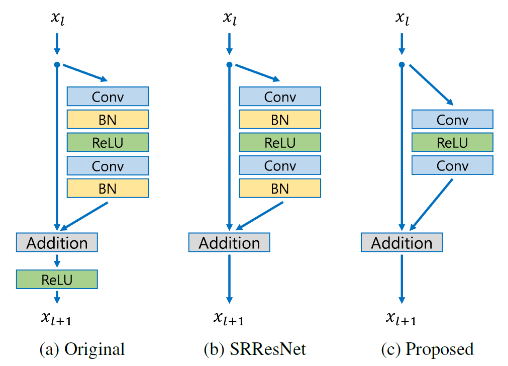

In [8]:
class EDSR_Model(tf.keras.Model):
    """Build Model
    1) train_step
    2) predict_step
    """
    
    def train_step(self, data):
        ## unpack the data
        
        x, y = data
                
        # Step 1: Forward pass
        with tf.GradientTape() as tape:
            ## tf.keras.Model의 call 메서드 호출
            y_prediction = self(x, training=True)
            
            # Step 2: loss value 계산
            loss = self.compiled_loss(y, y_prediction, regularization_losses=self.losses)
            
        # Step 3: Gradient 계산
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Step 4: update weights using the optimizer
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Step 5: Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_prediction)

        # Step 6: Return a dictionary mapping metric names to current values
        # This is typically used to monitor metrics during training
        return {metric.name: metric.result() for metric in self.metrics}
    
    
    def predict_step(self, x):
        # Add a batch dimension and cast to float32
        x_batch = tf.cast(tf.expand_dims(x, axis=0), tf.float32)

        # Perform super-resolution prediction / low resolution image passing to model
        super_resolution_img = self(x_batch, training=False)

        # Clip values to the range [0, 255]
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)

        # Round values to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)

        # Remove batch dimension(size 1) and cast to uint8
        super_resolution_img = tf.squeeze(tf.cast(super_resolution_img, tf.uint8), axis=0)

        return super_resolution_img

In [13]:
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSR_Model(input_layer, output_layer)


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [10]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

>### Train the model

In [14]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100
200/200 [==============================] - 40s 135ms/step - loss: 25.0565 - PSNR: 21.0369 - val_loss: 13.4057 - val_PSNR: 22.8386
Epoch 2/100
200/200 [==============================] - 17s 85ms/step - loss: 12.8272 - PSNR: 26.7101 - val_loss: 11.5399 - val_PSNR: 25.7230
Epoch 3/100
200/200 [==============================] - 17s 85ms/step - loss: 10.9616 - PSNR: 29.0399 - val_loss: 10.4933 - val_PSNR: 23.8547
Epoch 4/100
200/200 [==============================] - 17s 85ms/step - loss: 10.2207 - PSNR: 30.3068 - val_loss: 9.7479 - val_PSNR: 25.9409
Epoch 5/100
200/200 [==============================] - 17s 85ms/step - loss: 9.5935 - PSNR: 30.2537 - val_loss: 8.9518 - val_PSNR: 30.5866
Epoch 6/100
200/200 [==============================] - 17s 84ms/step - loss: 9.5586 - PSNR: 30.9020 - val_loss: 8.0998 - val_PSNR: 30.5628
Epoch 7/100
200/200 [==============================] - 17s 84ms/step - loss: 9.1554 - PSNR: 30.1776 - val_loss: 8.7845 - val_PSNR: 28.0016
Epoch 8/100
200/200

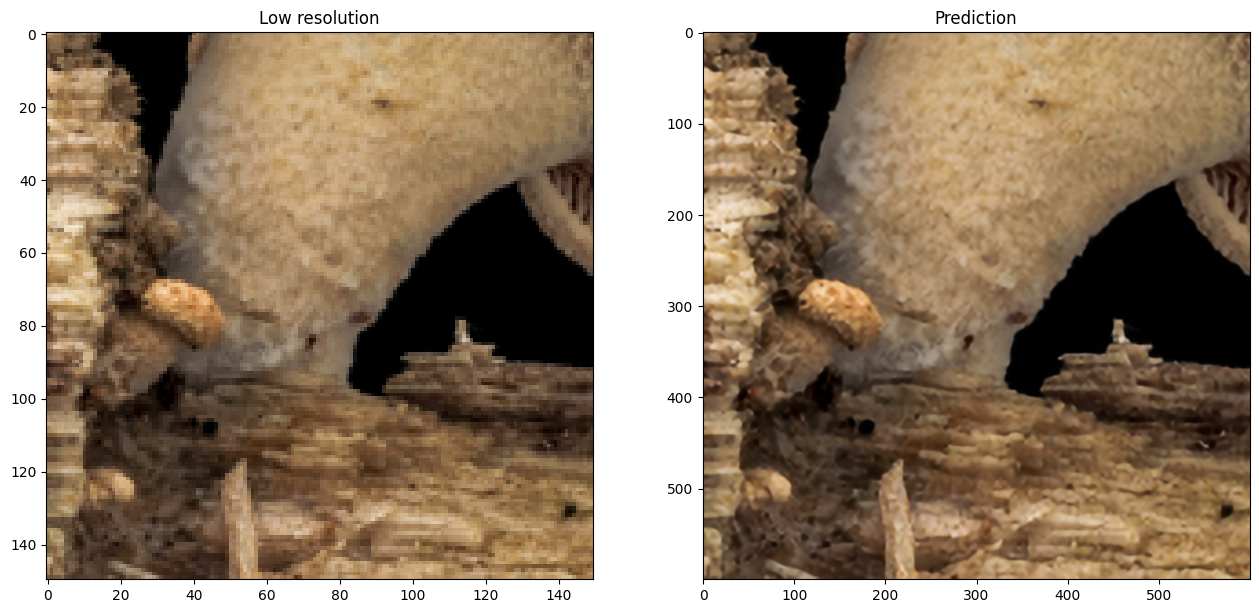

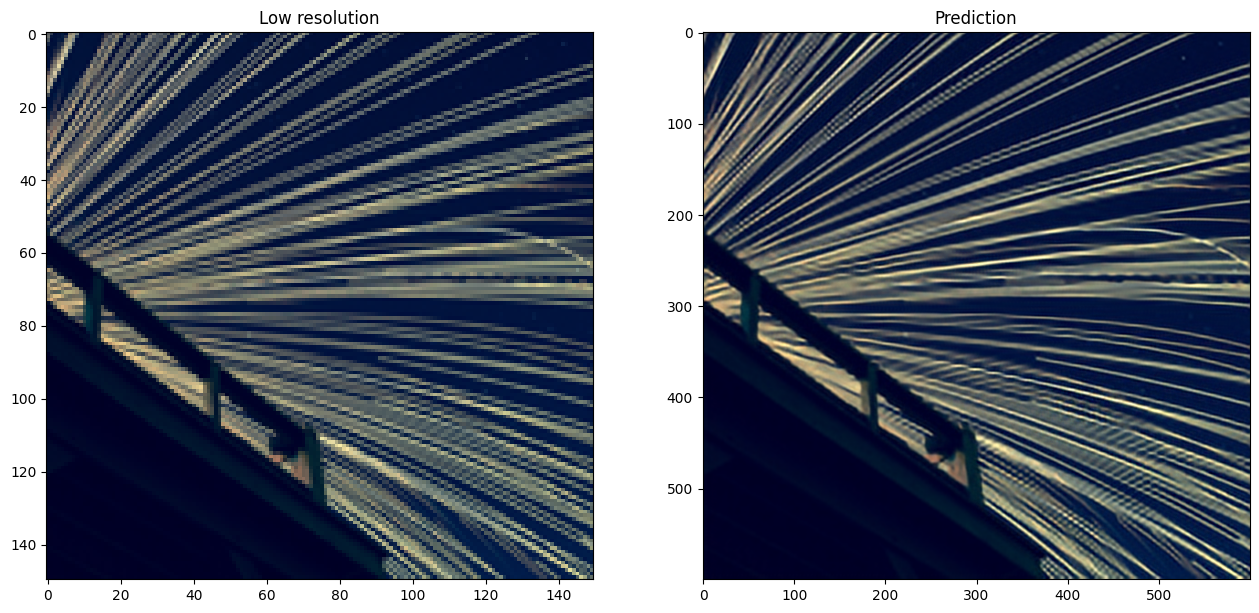

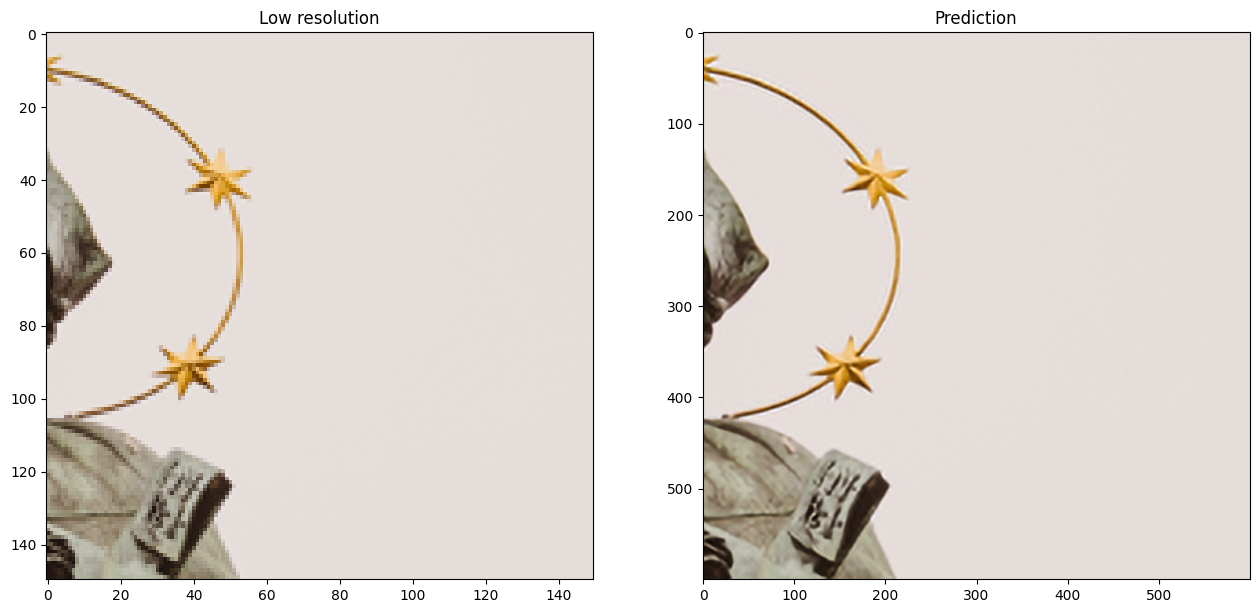

In [15]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in validation_data.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)